In [1]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import keras
import random
import pandas as pd
from PIL import Image
import cv2
import matplotlib.image as mpimg
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.imagenet_utils import decode_predictions

from keras_efficientnets import EfficientNetB0,EfficientNetB3
#from keras_efficientnets import center_crop_and_resize, preprocess_input
from keras.optimizers import SGD, Adam
from keras.layers.pooling import MaxPooling2D,AveragePooling2D


Using TensorFlow backend.


In [2]:
#绘制loss和acc曲线函数
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

## 使用Keras回调函数进行随机权重平均(SWA)
* 传统的集成方法是集成几种不同的模型，再用相同的输入对模型进行预测，然后使用某种平均方法来确定集成模型的最终预测。
* 当集成方法与深度学习相结合时，可以通过组合多个神经网络的预测来产生最终的预测结果。通常，集成不同结构的神经网络会得到一个性能不错的集成模型，因为每种模型可能在不同的训练样本上犯错，因此这样的集成方法能够最大化地提升模型的最终性能。
* 但是，你也可以集成相同结构的神经网络模型，这种集成方式也可以获得出人意料的好结果。随机加权平均(SWA）。
* SWA 的观点是来自经验观察，即每个学习速率周期结束时的局部最小值都倾向于在损失平面上损失值低的区域边界处累积。通过平均化这种点的损失值，可以得到具有更低损失值、泛化性和通用性更好的全局最优解。第一个模型用来存储模型权重的平均值 。这将在训练结束后得到最终的模型，并用于预测。 第二个模型用来穿过权重空间，并使用循环学习率进行探索。在每个学习速率周期结束时，将使用第二个模型的当前权重，通过在旧的平均权重和第二个模型的新权重集合之间进行加权平均值来更新模型的平均权重。按照这种方法，你只需要训练一个模型，并且在训练期间将两个模型存储在内存中。在预测阶段，你只需要那个具有平均权重的模型，并对其进行预测，这比使用上述那些需要使用多个模型来进行预测的集成方法要快得多。

In [3]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

import  keras.callbacks as callbacks

class SWA(callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

## 训练集和验证集的数据预处理

In [4]:
#训练集执行各种变换，旋转，裁减，翻转等
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        '/media/design/0D7907FA0D7907FA/数据集3/hazeremoval/data/train',
        target_size=(299, 299),
        batch_size=10,
        class_mode='categorical',shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        '/media/design/0D7907FA0D7907FA/数据集3/hazeremoval/data/valid',
        target_size=(299, 299),
        batch_size=10,
        class_mode='categorical',shuffle=False)


Found 262 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


In [5]:
train_generator.class_indices

{'无污染': 0, '轻度污染': 1, '重度污染': 2}

In [6]:
from  keras.layers import Dense, Activation, Flatten, Dropout
from  keras.models import Sequential, Model

 
#建立模型函数
def build_finetune_model(base_model, dropout, num_classes):

    x = base_model.output
    
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
#     x = Dropout(0.25)(x)
#     x = Dense(512,activation='relu')(x)
    x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    

    return finetune_model

### 设置参数 建立模型

In [7]:
HEIGHT = 299 #高度
WIDTH = 299  #宽度

input_shape=(HEIGHT, WIDTH, 3) #输入shape

FC_LAYERS = [1024]#全连接层核的数量
dropout = 0.7  #dropout 系数
epochs = 18  #批次
swa = SWA('./keras_swa.model',epochs-3) #SWA函数
# 标签平滑
def mycrossentropy(y_true, y_pred, e=0.1):
    loss1 = K.categorical_crossentropy(y_true, y_pred)
    #loss2 = K.categorical_crossentropy(K.ones_like(y_pred)/nb_classes, y_pred)
    return (1-e)*loss1 + e/3
#基础模型
base_model = EfficientNetB0(weights='imagenet',
                            include_top=False,
                            input_shape=(HEIGHT, WIDTH, 3))
#建立带196分类器模型
finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      num_classes=3)
#编译模型
finetune_model.compile(optimizer='adam', loss=mycrossentropy, metrics=['accuracy'])

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
history = finetune_model.fit_generator(generator=train_generator,
                                        validation_data=validation_generator,
                                        steps_per_epoch=33,
                                        epochs=epochs,verbose=2,validation_steps=7,callbacks=snapshot.get_callbacks())

#保存模型
finetune_model.save_weights('model_Fog.h5')
try:
    finetune_model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)

Stochastic weight averaging selected for last 3 epochs.
Epoch 1/20
 - 35s - loss: 0.6942 - acc: 0.6672 - val_loss: 0.4700 - val_acc: 0.8000
Epoch 2/20
 - 17s - loss: 0.3442 - acc: 0.8666 - val_loss: 0.5674 - val_acc: 0.7538
Epoch 3/20
 - 19s - loss: 0.4660 - acc: 0.8396 - val_loss: 0.5559 - val_acc: 0.7692
Epoch 4/20
 - 18s - loss: 0.2462 - acc: 0.9181 - val_loss: 0.6744 - val_acc: 0.7385
Epoch 5/20
 - 19s - loss: 0.2627 - acc: 0.9063 - val_loss: 1.3169 - val_acc: 0.6308
Epoch 6/20
 - 19s - loss: 0.3706 - acc: 0.8788 - val_loss: 0.7916 - val_acc: 0.7846
Epoch 7/20
 - 16s - loss: 0.2232 - acc: 0.9397 - val_loss: 0.9779 - val_acc: 0.8154
Epoch 8/20
 - 16s - loss: 0.1745 - acc: 0.9514 - val_loss: 0.4540 - val_acc: 0.8769
Epoch 9/20
 - 16s - loss: 0.2327 - acc: 0.9363 - val_loss: 0.3207 - val_acc: 0.9077
Epoch 10/20
 - 17s - loss: 0.1091 - acc: 0.9727 - val_loss: 0.6111 - val_acc: 0.8154
Epoch 11/20
 - 17s - loss: 0.1149 - acc: 0.9697 - val_loss: 0.4824 - val_acc: 0.8615
Epoch 12/20
 - 16s

In [8]:
#finetune_model.save_weights('model2.h5')

In [9]:
#finetune_model.load_weights('model2.h5')

### 打印loss，acc曲线

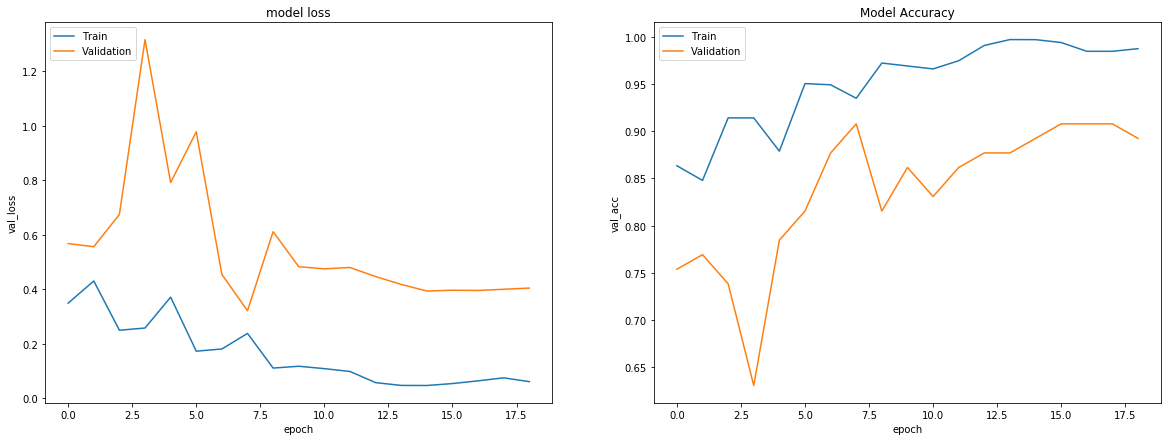

In [10]:
plot_loss_acc(history)

### 预测测试集及可视化

In [11]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import os
# 载入模型
finetune_model.load_weights('model_Fog.h5', by_name=True)
label = np.array(['无污染', '轻度污染', '重度污染'])
#图片缩放到299*299
def image_change(image):
    image = image.resize((299,299))
    image = img_to_array(image)
    image = image/255
    image = np.expand_dims(image,0)
    return image

图片真实分类为 0324无污染.jpg


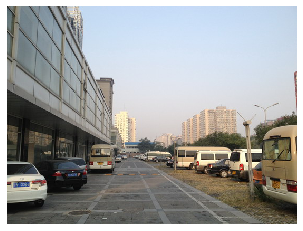

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 SJZ_Bing_683轻度污染.png


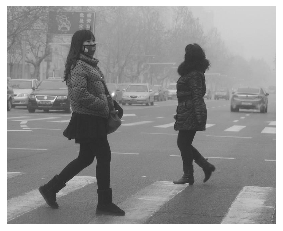

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 0004无污染.jpg


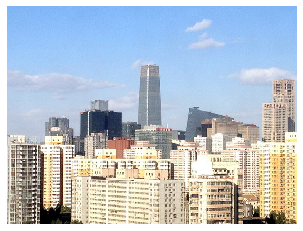

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0013无污染.jpg


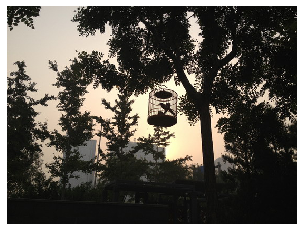

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0032无污染.jpg


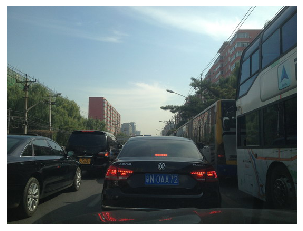

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0219无污染.jpg


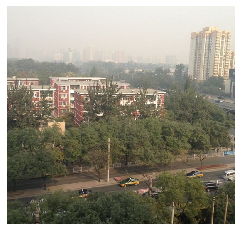

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0228无污染.jpg


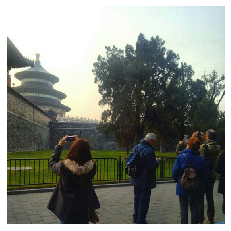

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0235无污染.jpg


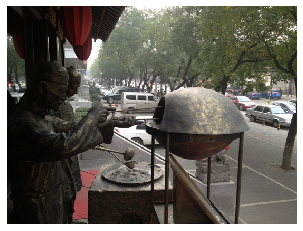

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0240无污染.jpg


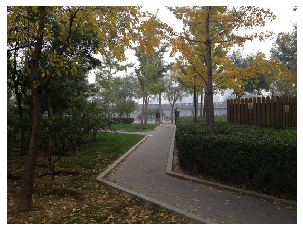

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0246无污染.jpg


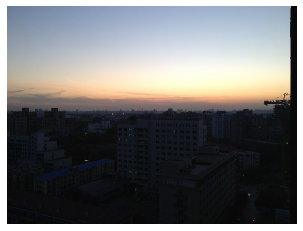

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0251无污染.jpg


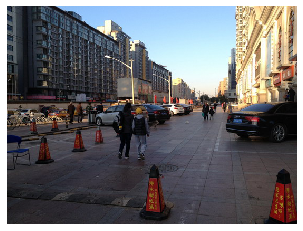

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0259无污染.jpg


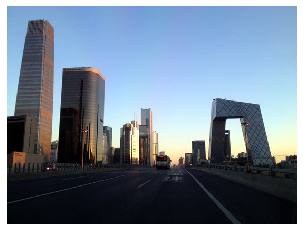

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0265无污染.jpg


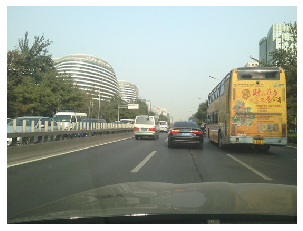

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0276无污染.jpg


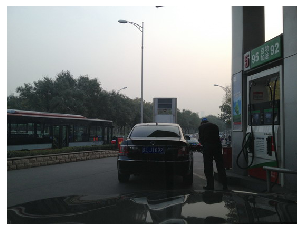

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0282无污染.jpg


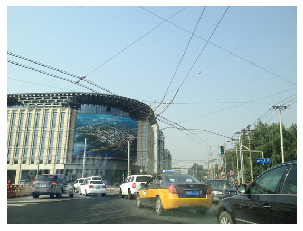

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0287无污染.jpg


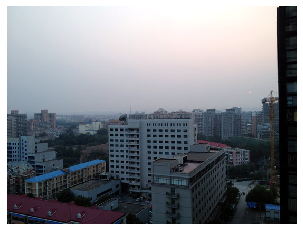

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0297无污染.jpg


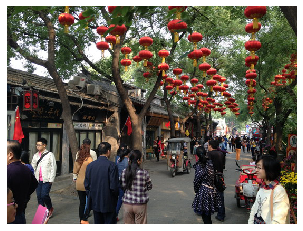

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0307无污染.jpg


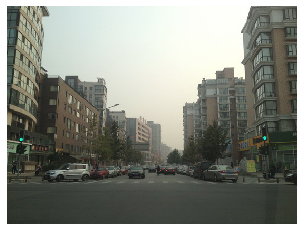

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0317无污染.jpg


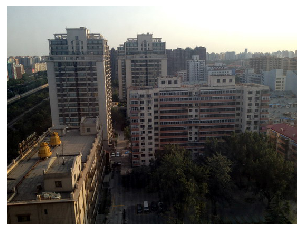

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 SJZ_Google_412轻度污染.png


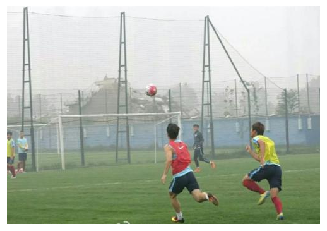

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 SY_Google_475轻度污染.png


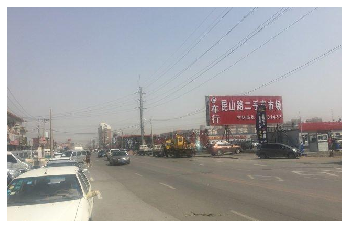

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 TJ_Baidu_559轻度污染.png


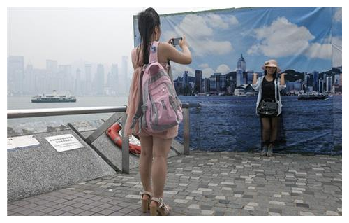

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 WST_Google_074轻度污染.png


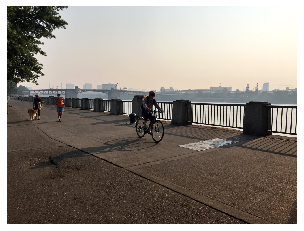

预测结果为 ['无污染']
预测错误
----------------------------------
图片真实分类为 XA_Baidu_127轻度污染.png


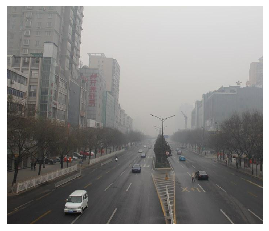

预测结果为 ['重度污染']
预测错误
----------------------------------
图片真实分类为 XA_Bing_090轻度污染.png


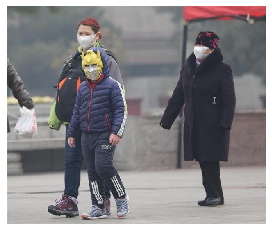

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 XA_Bing_471轻度污染.png


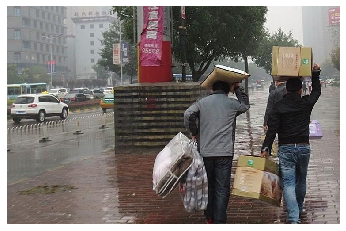

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 XA_Google_586轻度污染.png


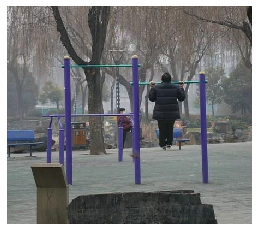

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 XR_Bing_024轻度污染.png


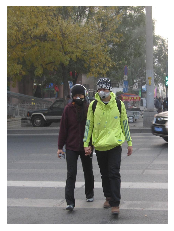

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 XR_Bing_40轻度污染.png


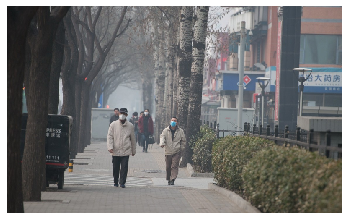

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 XR_Google_142轻度污染.png


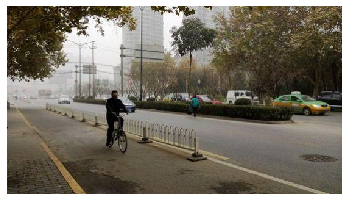

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 XR_Google_633轻度污染.png


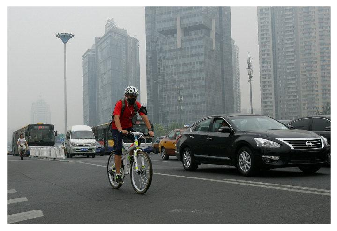

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 YC_Bing_731轻度污染.png


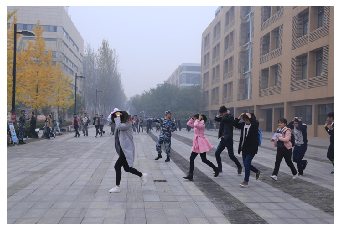

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 YT_Google_296轻度污染.png


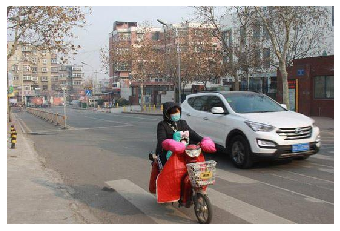

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 0333无污染.jpg


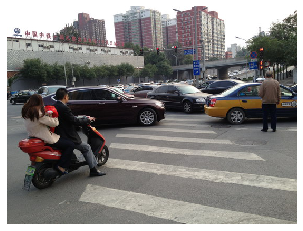

预测结果为 ['无污染']
预测正确
----------------------------------
图片真实分类为 0345无污染.jpg


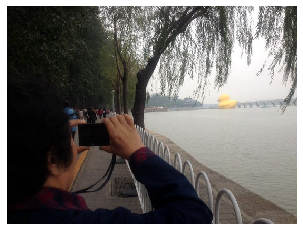

预测结果为 ['轻度污染']
预测错误
----------------------------------
图片真实分类为 AM_Bing_536重度污染.png


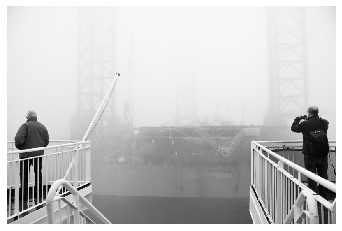

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 AM_Google_707重度污染.png


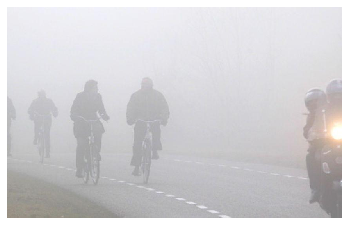

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BD_Baidu_050重度污染.png


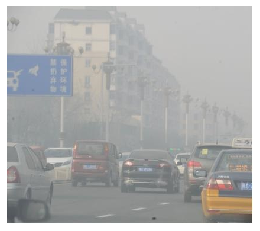

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BD_Baidu_116重度污染.png


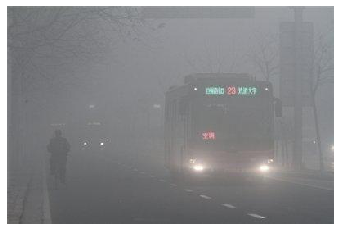

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BD_Baidu_284重度污染.png


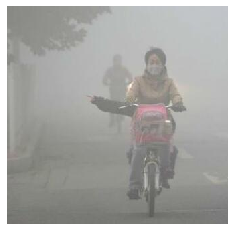

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BD_Baidu_397重度污染.png


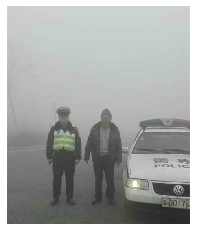

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BD_Bing_195重度污染.png


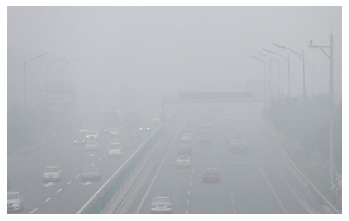

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BD_Google_435重度污染.png


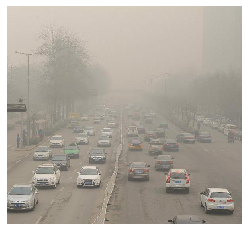

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BJ_Baidu_171重度污染.png


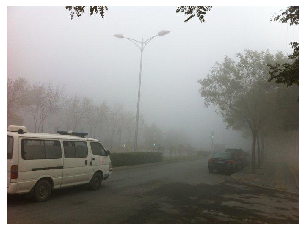

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BJ_Baidu_589重度污染.png


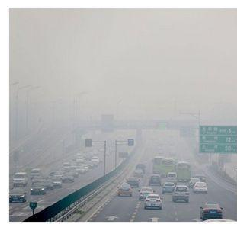

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BJ_Bing_651重度污染.png


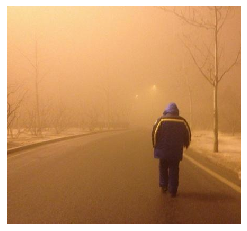

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BJ_Google_24重度污染.png


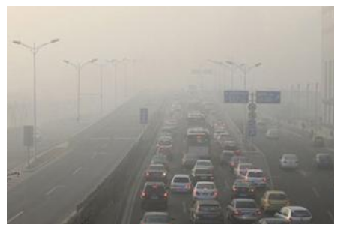

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BJ_Google_447重度污染.png


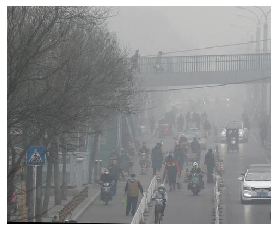

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BJ_Google_471重度污染.png


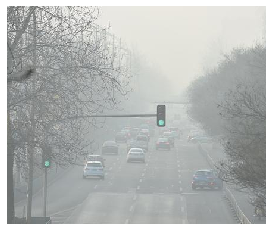

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 BL_Bing_273重度污染.png


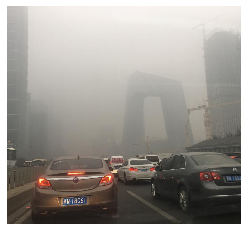

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 CC_Baidu_137重度污染.png


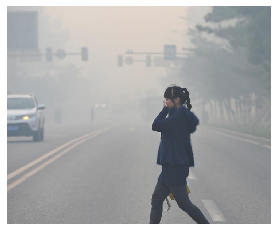

预测结果为 ['轻度污染']
预测错误
----------------------------------
图片真实分类为 CC_Bing_242重度污染.png


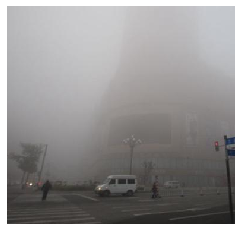

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 CD_Baidu_352重度污染.png


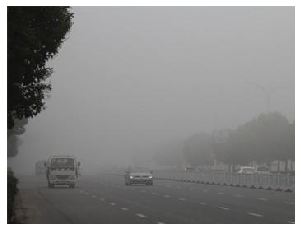

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 CD_Google_239重度污染.png


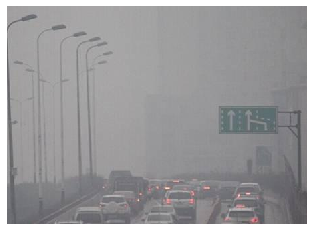

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 CQ_Google_52重度污染.png


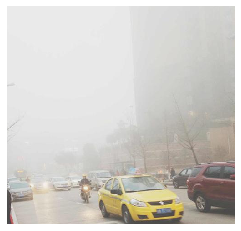

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 DJ_Bing_021重度污染.png


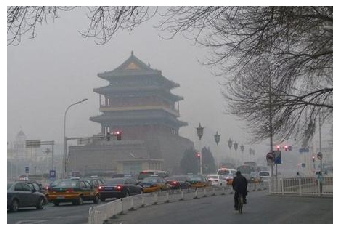

预测结果为 ['轻度污染']
预测错误
----------------------------------
图片真实分类为 FogDr_Bing_410重度污染.png


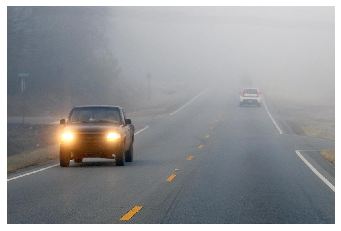

预测结果为 ['重度污染']
预测正确
----------------------------------
图片真实分类为 PL_Bing_244轻度污染.png


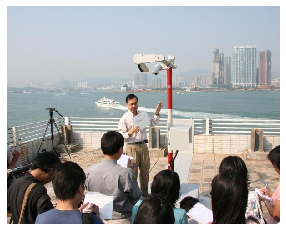

预测结果为 ['无污染']
预测错误
----------------------------------
图片真实分类为 QC_Bing_867轻度污染.png


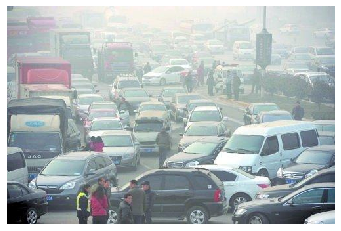

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 SFC_Google_069轻度污染.png


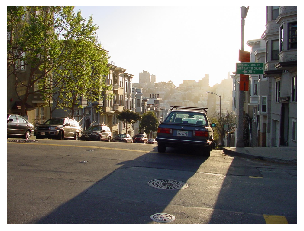

预测结果为 ['无污染']
预测错误
----------------------------------
图片真实分类为 SGP_Bing_125轻度污染.png


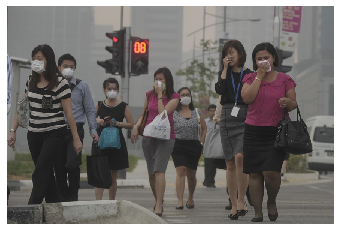

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 SGP_Google_075轻度污染.png


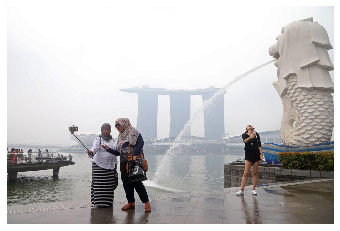

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 SH_Bing_503轻度污染.png


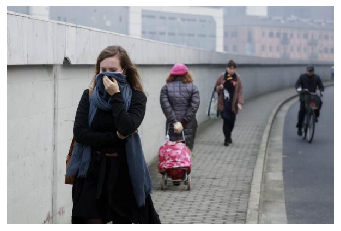

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 SJZ_Baidu_716轻度污染.png


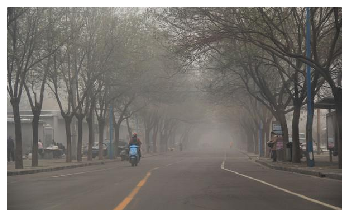

预测结果为 ['轻度污染']
预测正确
----------------------------------
图片真实分类为 SJZ_Bing_410轻度污染.png


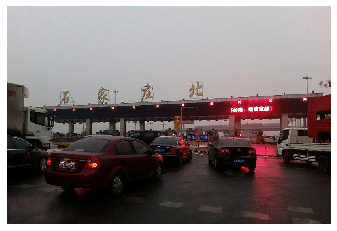

预测结果为 ['轻度污染']
预测正确
----------------------------------
Test-set classification accuracy: 89.23%


In [12]:
#预测test2的图片
true_num=0
total_num=0
for pic in os.listdir('/media/design/0D7907FA0D7907FA/数据集3/hazeremoval/data/test2'):
    print('图片真实分类为',pic)
    image = load_img('/media/design/0D7907FA0D7907FA/数据集3/hazeremoval/data/test2/' + pic)
    image = image_change(image)
    lena = mpimg.imread('/media/design/0D7907FA0D7907FA/数据集3/hazeremoval/data/test2/' + pic)


    plt.imshow(lena) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    predict = finetune_model.predict(image)
    predict=np.argmax(predict,axis=1)
    print('预测结果为',label[predict])
    str5=''.join(label[predict])
    #例如文件名为0123_0.jpg预测结果为 ['0123']，真实文件名包含'0123'子字符串则表示预测正确
    if pic.find(str5, 0, len(pic))>= 0:
        true_num=true_num+1
        print('预测正确')
    else:
        print('预测错误')
    total_num=total_num+1
    print('----------------------------------')
    #打印出所有的图片的预测acc
print("Test-set classification accuracy: {0:.2%}".format(true_num/total_num))